### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from Helper_functions import *

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OrdinalEncoder

In [3]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE 

### Read in Song Data

In [4]:
song_features = pd.read_csv('Data/SpotifyFeatures.csv')
song_features = song_features.rename(columns={"track_name":"trackName","artist_name":"artistName"})
song_features.drop(['track_id'], axis=1, inplace = True)

### Issue: Many Songs Show Up Multiple Times

In [5]:
num_duplicate_songs = len(song_features) - len(song_features.trackName.unique())
num_duplicate_songs

84110

### Duplicates Due to Multiple Genres Associated With One Song

In [6]:
song_features[song_features.duplicated('trackName', keep=False) == True].sort_values(by=['trackName'])

,genre,artistName,trackName,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
121128,Rap,Rae Sremmurd,"""42"" - From SR3MM",53,0.00275,0.968,238020,0.563,0.000000,C#,0.108,-6.744,Major,0.1250,130.039,4/4,0.324
89661,Hip-Hop,Rae Sremmurd,"""42"" - From SR3MM",53,0.00275,0.968,238020,0.563,0.000000,C#,0.108,-6.744,Major,0.1250,130.039,4/4,0.324
77209,Children’s Music,Barns Courtney,"""99""",69,0.00598,0.552,199413,0.804,0.000000,G#,0.111,-4.299,Major,0.0303,95.980,4/4,0.714
166523,Rock,Barns Courtney,"""99""",69,0.00598,0.552,199413,0.804,0.000000,G#,0.111,-4.299,Major,0.0303,95.980,4/4,0.714
1441,Alternative,Barns Courtney,"""99""",62,0.00598,0.552,199413,0.804,0.000000,G#,0.111,-4.299,Major,0.0303,95.980,4/4,0.714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54841,R&B,TAEYANG,"눈,코,입(Eyes, Noes, Lips)",66,0.73800,0.631,229990,0.516,0.000000,C,0.264,-5.759,Major,0.0378,143.777,4/4,0.254
113088,Pop,Hyolyn,달리,66,0.29300,0.666,203000,0.820,0.000000,B,0.249,-2.886,Minor,0.2080,143.741,4/4,0.883
54063,R&B,Hyolyn,달리,66,0.29300,0.666,203000,0.820,0.000000,B,0.249,-2.886,Minor,0.2080,143.741,4/4,0.883
143505,Indie,Paul Kim,"모든 날, 모든 순간 Every day, Every Moment",56,0.85900,0.470,210493,0.288,0.000018,G#,0.103,-9.434,Major,0.0279,133.250,4/4,0.153


### Analysis of Odd Genre Categories

In [7]:
song_features.genre.unique()

array(['Movie', 'R&B', 'A Capella', 'Alternative', 'Country', 'Dance',
       'Electronic', 'Anime', 'Folk', 'Blues', 'Opera', 'Hip-Hop',
       "Children's Music", 'Children’s Music', 'Rap', 'Indie',
       'Classical', 'Pop', 'Reggae', 'Reggaeton', 'Jazz', 'Rock', 'Ska',
       'Comedy', 'Soul', 'Soundtrack', 'World'], dtype=object)

In [8]:
comedy_data = song_features[song_features['genre'] == 'Comedy']
comedy_data.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,9681.000000,9681.000000,9681.000000,9.681000e+03,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000
mean,21.342630,0.793098,0.559038,2.353052e+05,0.676094,0.000574,0.724775,-11.689321,0.853532,98.235488,0.412764
std,8.428764,0.130313,0.089625,2.502539e+05,0.211705,0.009987,0.223437,4.777983,0.205918,27.839986,0.207258
min,0.000000,0.000363,0.239000,3.004000e+04,0.001410,0.000000,0.025800,-31.047000,0.023000,32.451000,0.023700
25%,15.000000,0.753000,0.499000,1.218800e+05,0.522000,0.000000,0.662000,-14.649000,0.888000,79.720000,0.252000
50%,20.000000,0.819000,0.561000,1.890570e+05,0.704000,0.000000,0.767000,-11.209000,0.928000,90.124000,0.410000
75%,26.000000,0.872000,0.620000,2.812930e+05,0.859000,0.000000,0.898000,-8.088000,0.944000,115.128000,0.561000
max,61.000000,0.995000,0.898000,5.552917e+06,0.998000,0.352000,0.996000,-0.255000,0.967000,207.157000,0.980000


In [9]:
movie_data = song_features[song_features['genre'] == 'Movie']
movie_data.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,7806.000000,7806.000000,7806.000000,7.806000e+03,7806.000000,7806.000000,7806.000000,7806.000000,7806.000000,7806.000000,7806.000000
mean,12.174097,0.697341,0.491186,2.104054e+05,0.370703,0.125427,0.228715,-12.952094,0.109400,113.946770,0.447808
std,13.613171,0.277379,0.178861,2.123862e+05,0.237548,0.281954,0.197256,5.635001,0.179151,30.346368,0.278910
min,0.000000,0.000014,0.065400,1.721300e+04,0.000216,0.000000,0.012100,-38.445000,0.022800,32.244000,0.000000
25%,1.000000,0.541000,0.352000,1.373632e+05,0.178000,0.000000,0.104000,-16.122250,0.035000,89.797500,0.203250
50%,7.000000,0.794000,0.503000,1.826130e+05,0.332500,0.000011,0.145000,-12.243000,0.043100,111.465000,0.410000
75%,20.000000,0.919000,0.630750,2.353532e+05,0.529000,0.007495,0.287000,-8.758750,0.076775,132.435500,0.678000
max,82.000000,0.996000,0.940000,3.832947e+06,0.995000,0.994000,0.988000,-1.828000,0.965000,232.602000,1.000000


In [10]:
without_comedy_data = song_features[song_features['genre'] != 'Comedy']
without_movie_comedy_data = without_comedy_data[without_comedy_data['genre'] != 'Movie']
without_movie_comedy_data.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,215238.000000,215238.000000,215238.000000,2.152380e+05,215238.000000,215238.000000,215238.000000,215238.000000,215238.000000,215238.000000,215238.000000
mean,43.067437,0.337542,0.556446,2.360105e+05,0.573491,0.155775,0.191584,-9.351895,0.088219,118.675465,0.457071
std,17.206645,0.345750,0.188621,1.040182e+05,0.262732,0.308501,0.163114,6.004909,0.094486,30.749913,0.261323
min,0.000000,0.000000,0.056900,1.538700e+04,0.000020,0.000000,0.009670,-52.457000,0.022200,30.379000,0.000000
25%,32.000000,0.030900,0.434000,1.862380e+05,0.393000,0.000000,0.095900,-11.279000,0.036400,93.998000,0.238000
50%,45.000000,0.191000,0.574000,2.220130e+05,0.609000,0.000076,0.124000,-7.514000,0.048700,117.044500,0.447000
75%,55.000000,0.630000,0.698000,2.662000e+05,0.788000,0.052900,0.234000,-5.393000,0.092100,139.962750,0.665000
max,100.000000,0.996000,0.989000,5.488000e+06,0.999000,0.999000,1.000000,3.744000,0.961000,242.903000,1.000000


### Remove Comedy Genre From Song Data

In [11]:
song_features = without_comedy_data
song_features

,genre,artistName,trackName,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0,0.61100,0.389,99373,0.910,0.000000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),1,0.24600,0.590,137373,0.737,0.000000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,3,0.95200,0.663,170267,0.131,0.000000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0,0.70300,0.240,152427,0.326,0.000000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,4,0.95000,0.331,82625,0.225,0.123000,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232720,Soul,Slave,Son Of Slide,39,0.00384,0.687,326240,0.714,0.544000,D,0.0845,-10.626,Major,0.0316,115.542,4/4,0.962
232721,Soul,Jr Thomas & The Volcanos,Burning Fire,38,0.03290,0.785,282447,0.683,0.000880,E,0.2370,-6.944,Minor,0.0337,113.830,4/4,0.969
232722,Soul,Muddy Waters,(I'm Your) Hoochie Coochie Man,47,0.90100,0.517,166960,0.419,0.000000,D,0.0945,-8.282,Major,0.1480,84.135,4/4,0.813
232723,Soul,R.LUM.R,With My Words,44,0.26200,0.745,222442,0.704,0.000000,A,0.3330,-7.137,Major,0.1460,100.031,4/4,0.489


### Read in my Personal Listening History

In [12]:
my_data0 = pd.read_json('Data/MyData/StreamingHistory0.json')
my_data1 = pd.read_json('Data/MyData/StreamingHistory1.json')

listening_data = pd.concat([my_data0,my_data1])

# Only keep songs that you have listened to for at least 10 seconds
listening_data = listening_data[listening_data['msPlayed'] >= 10000]

listening_data

,endTime,artistName,trackName,msPlayed
0,2019-11-12 21:55,Watsky,Talking to Myself,36325
1,2019-11-13 01:02,ILLENIUM,Good Things Fall Apart (with Jon Bellion),216668
2,2019-11-13 01:09,Jonas Blue,Rise,381505
4,2019-11-13 01:12,Watsky,Talking to Myself,220893
6,2019-11-13 02:23,Watsky,Talking to Myself,220893
...,...,...,...,...
439,2020-11-13 23:40,blackbear,queen of broken hearts,171171
440,2020-11-13 23:43,blackbear,i feel bad,175066
442,2020-11-13 23:46,Jawsh 685,Sweet & Sour (feat. Lauv & Tyga),163228
443,2020-11-13 23:49,Shawn Mendes,Wonder,172692


In [13]:
listening_data.drop(['endTime', 'msPlayed'], axis=1, inplace = True)
count_vals = listening_data.groupby('trackName')['trackName'].agg(['count'])
count_vals.sort_values(by=['count'], ascending = False, inplace = True)
count_vals

,count
trackName,
Good Things Fall Apart (with Jon Bellion),100
Stacy,97
White Walls (feat. ScHoolboy Q & Hollis),87
I Don't Belong In This Club,85
comethru,84
...,...
Get Lucky (feat. Pharrell Williams & Nile Rodgers) - Radio Edit,1
Gettin' Mine,1
Ghost,1


### Join my Personal Data with Song Data

In [14]:
final = listening_data.merge(song_features, how='inner', left_on=["trackName", "artistName"], right_on=["trackName","artistName"])
final = final.merge(count_vals, how='inner',left_on=['trackName'],right_on=['trackName'])
final['count'] = final['count'].map(is_favorite_song)
final = final.rename(columns={"count":"is_favorite"})
final

,artistName,trackName,genre,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,is_favorite
0,Watsky,Talking to Myself,Hip-Hop,51,0.409,0.693,220893,0.647,0.125,A,0.1060,-9.417,Minor,0.0793,151.948,4/4,0.340,Favorite
1,Watsky,Talking to Myself,Rap,51,0.409,0.693,220893,0.647,0.125,A,0.1060,-9.417,Minor,0.0793,151.948,4/4,0.340,Favorite
2,Watsky,Talking to Myself,Indie,51,0.409,0.693,220893,0.647,0.125,A,0.1060,-9.417,Minor,0.0793,151.948,4/4,0.340,Favorite
3,Watsky,Talking to Myself,Hip-Hop,51,0.409,0.693,220893,0.647,0.125,A,0.1060,-9.417,Minor,0.0793,151.948,4/4,0.340,Favorite
4,Watsky,Talking to Myself,Rap,51,0.409,0.693,220893,0.647,0.125,A,0.1060,-9.417,Minor,0.0793,151.948,4/4,0.340,Favorite
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10007,Dean Lewis,Be Alright,Pop,92,0.697,0.553,196373,0.586,0.000,B,0.0813,-6.319,Major,0.0362,126.684,4/4,0.443,Favorite
10008,Dean Lewis,Be Alright,Pop,92,0.697,0.553,196373,0.586,0.000,B,0.0813,-6.319,Major,0.0362,126.684,4/4,0.443,Favorite
10009,Dean Lewis,Be Alright,Pop,92,0.697,0.553,196373,0.586,0.000,B,0.0813,-6.319,Major,0.0362,126.684,4/4,0.443,Favorite
10010,Dean Lewis,Be Alright,Pop,92,0.697,0.553,196373,0.586,0.000,B,0.0813,-6.319,Major,0.0362,126.684,4/4,0.443,Favorite


### Clearly There are MANY Duplicates

In [15]:
final[final['artistName'] == 'Dean Lewis']

,artistName,trackName,genre,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,is_favorite
9998,Dean Lewis,Be Alright,Pop,92,0.697,0.553,196373,0.586,0.0,B,0.0813,-6.319,Major,0.0362,126.684,4/4,0.443,Favorite
9999,Dean Lewis,Be Alright,Pop,92,0.697,0.553,196373,0.586,0.0,B,0.0813,-6.319,Major,0.0362,126.684,4/4,0.443,Favorite
10000,Dean Lewis,Be Alright,Pop,92,0.697,0.553,196373,0.586,0.0,B,0.0813,-6.319,Major,0.0362,126.684,4/4,0.443,Favorite
10001,Dean Lewis,Be Alright,Pop,92,0.697,0.553,196373,0.586,0.0,B,0.0813,-6.319,Major,0.0362,126.684,4/4,0.443,Favorite
10002,Dean Lewis,Be Alright,Pop,92,0.697,0.553,196373,0.586,0.0,B,0.0813,-6.319,Major,0.0362,126.684,4/4,0.443,Favorite
10003,Dean Lewis,Be Alright,Pop,92,0.697,0.553,196373,0.586,0.0,B,0.0813,-6.319,Major,0.0362,126.684,4/4,0.443,Favorite
10004,Dean Lewis,Be Alright,Pop,92,0.697,0.553,196373,0.586,0.0,B,0.0813,-6.319,Major,0.0362,126.684,4/4,0.443,Favorite
10005,Dean Lewis,Be Alright,Pop,92,0.697,0.553,196373,0.586,0.0,B,0.0813,-6.319,Major,0.0362,126.684,4/4,0.443,Favorite
10006,Dean Lewis,Be Alright,Pop,92,0.697,0.553,196373,0.586,0.0,B,0.0813,-6.319,Major,0.0362,126.684,4/4,0.443,Favorite
10007,Dean Lewis,Be Alright,Pop,92,0.697,0.553,196373,0.586,0.0,B,0.0813,-6.319,Major,0.0362,126.684,4/4,0.443,Favorite


In [16]:
final.drop_duplicates(inplace=True)
final

,artistName,trackName,genre,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,is_favorite
0,Watsky,Talking to Myself,Hip-Hop,51,0.4090,0.693,220893,0.647,0.125000,A,0.1060,-9.417,Minor,0.0793,151.948,4/4,0.340,Favorite
1,Watsky,Talking to Myself,Rap,51,0.4090,0.693,220893,0.647,0.125000,A,0.1060,-9.417,Minor,0.0793,151.948,4/4,0.340,Favorite
2,Watsky,Talking to Myself,Indie,51,0.4090,0.693,220893,0.647,0.125000,A,0.1060,-9.417,Minor,0.0793,151.948,4/4,0.340,Favorite
96,Jonas Blue,Rise,Dance,86,0.3230,0.690,194408,0.784,0.000000,C#,0.2030,-4.653,Major,0.0320,106.066,4/4,0.669,Favorite
97,Jonas Blue,Rise,Pop,86,0.3230,0.690,194408,0.784,0.000000,C#,0.2030,-4.653,Major,0.0320,106.066,4/4,0.669,Favorite
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,ScHoolboy Q,Collard Greens,Pop,73,0.0250,0.825,299960,0.575,0.000010,B,0.2050,-4.870,Major,0.0633,153.954,4/4,0.650,Not favorite
9995,Twenty One Pilots,Pet Cheetah,Pop,72,0.0615,0.653,198360,0.684,0.000387,G,0.2700,-7.052,Minor,0.1990,110.049,4/4,0.355,Not favorite
9996,Twenty One Pilots,Pet Cheetah,Rock,72,0.0615,0.653,198360,0.684,0.000387,G,0.2700,-7.052,Minor,0.1990,110.049,4/4,0.355,Not favorite
9997,Twenty One Pilots,Legend,Rock,70,0.0948,0.716,172560,0.575,0.000257,C,0.0829,-6.209,Major,0.0368,85.937,4/4,0.797,Not favorite


In [17]:
len(final.trackName.unique())

534

### We will attempt to get all song genres into one row

In [18]:
new_df = combine_genres(final)

In [19]:
new_df

,artistName,trackName,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,...,Pop,Alternative,Children’s Music,Rock,Folk,Electronic,Reggae,R&B,Soul,Country
0,Watsky,Talking to Myself,0.409000,0.693,220893,0.647,0.125000,A,0.1060,-9.417,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Jonas Blue,Rise,0.323000,0.690,194408,0.784,0.000000,C#,0.2030,-4.653,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Wiz Khalifa,No Sleep,0.109000,0.653,191320,0.711,0.000000,A,0.4430,-6.454,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Two Door Cinema Club,Changing of the Seasons,0.000052,0.544,222880,0.865,0.000290,D,0.1160,-4.644,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Thirty Seconds To Mars,Walk On Water,0.000092,0.495,185467,0.787,0.000000,G#,0.1670,-6.890,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532,Valee,Womp Womp,0.066000,0.877,226533,0.558,0.000000,C#,0.0745,-4.896,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
533,ScHoolboy Q,Collard Greens,0.025000,0.825,299960,0.575,0.000010,B,0.2050,-4.870,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
534,Twenty One Pilots,Pet Cheetah,0.061500,0.653,198360,0.684,0.000387,G,0.2700,-7.052,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
535,Twenty One Pilots,Legend,0.094800,0.716,172560,0.575,0.000257,C,0.0829,-6.209,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
'''# Assigning numerical values and storing in another column
labelencoder = LabelEncoder()
# new_df['artistName_cat'] = labelencoder.fit_transform(new_df['artistName'])
new_df['trackName_cat'] = labelencoder.fit_transform(new_df['trackName'])
new_df['key_cat'] = labelencoder.fit_transform(new_df['key'])
new_df['mode_cat'] = labelencoder.fit_transform(new_df['mode'])
new_df['time_signature_cat'] = labelencoder.fit_transform(new_df['time_signature'])

# new_df.drop(['artistName', 'trackName', 'key', 'mode', 'time_signature'], axis=1, inplace = True)
new_df.drop(['key', 'mode', 'time_signature'], axis=1, inplace = True)

new_df'''

"# Assigning numerical values and storing in another column\nlabelencoder = LabelEncoder()\n# new_df['artistName_cat'] = labelencoder.fit_transform(new_df['artistName'])\nnew_df['trackName_cat'] = labelencoder.fit_transform(new_df['trackName'])\nnew_df['key_cat'] = labelencoder.fit_transform(new_df['key'])\nnew_df['mode_cat'] = labelencoder.fit_transform(new_df['mode'])\nnew_df['time_signature_cat'] = labelencoder.fit_transform(new_df['time_signature'])\n\n# new_df.drop(['artistName', 'trackName', 'key', 'mode', 'time_signature'], axis=1, inplace = True)\nnew_df.drop(['key', 'mode', 'time_signature'], axis=1, inplace = True)\n\nnew_df"

In [21]:
OHE('artistName',  new_df)
OHE('trackName', new_df)
OHE('key',  new_df)
OHE('mode', new_df)
OHE('time_signature', new_df)

new_df.drop(['artistName', 'trackName', 'key', 'mode', 'time_signature'], axis=1, inplace = True)

new_df

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,...,F,G,C,A#,D#,Minor,Major,4/4,3/4,5/4
0,0.409000,0.693,220893,0.647,0.125000,0.1060,-9.417,0.0793,151.948,0.340,...,0,0,0,0,0,1,0,1,0,0
1,0.323000,0.690,194408,0.784,0.000000,0.2030,-4.653,0.0320,106.066,0.669,...,0,0,0,0,0,0,1,1,0,0
2,0.109000,0.653,191320,0.711,0.000000,0.4430,-6.454,0.0623,160.048,0.769,...,0,0,0,0,0,0,1,1,0,0
3,0.000052,0.544,222880,0.865,0.000290,0.1160,-4.644,0.1370,130.014,0.593,...,0,0,0,0,0,0,1,1,0,0
4,0.000092,0.495,185467,0.787,0.000000,0.1670,-6.890,0.0368,140.003,0.388,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532,0.066000,0.877,226533,0.558,0.000000,0.0745,-4.896,0.3420,157.027,0.493,...,0,0,0,0,0,0,1,1,0,0
533,0.025000,0.825,299960,0.575,0.000010,0.2050,-4.870,0.0633,153.954,0.650,...,0,0,0,0,0,0,1,1,0,0
534,0.061500,0.653,198360,0.684,0.000387,0.2700,-7.052,0.1990,110.049,0.355,...,0,1,0,0,0,1,0,1,0,0
535,0.094800,0.716,172560,0.575,0.000257,0.0829,-6.209,0.0368,85.937,0.797,...,0,0,1,0,0,0,1,1,0,0


In [22]:
# new_df.at[536, 'Twenty One Pilots'] == 1

In [23]:
type(new_df)

pandas.core.frame.DataFrame

# FEATURE SELECTION EDA

In [24]:
# plt.figure(figsize=(25,25))
# cor = new_df.corr()
# sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
# plt.show()

## Train/Test Split

In [25]:
Y = new_df['is_favorite'].to_numpy()
X = new_df.drop(columns = ['is_favorite']).to_numpy()

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=0)

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [27]:
y_train

array(['Not favorite', 'Not favorite', 'Not favorite', 'Not favorite',
       'Favorite', 'Not favorite', 'Not favorite', 'Not favorite',
       'Not favorite', 'Not favorite', 'Not favorite', 'Not favorite',
       'Favorite', 'Not favorite', 'Not favorite', 'Not favorite',
       'Not favorite', 'Not favorite', 'Not favorite', 'Favorite',
       'Favorite', 'Not favorite', 'Not favorite', 'Not favorite',
       'Not favorite', 'Not favorite', 'Not favorite', 'Not favorite',
       'Not favorite', 'Favorite', 'Not favorite', 'Not favorite',
       'Favorite', 'Favorite', 'Not favorite', 'Not favorite',
       'Not favorite', 'Not favorite', 'Favorite', 'Not favorite',
       'Favorite', 'Favorite', 'Not favorite', 'Not favorite',
       'Not favorite', 'Not favorite', 'Favorite', 'Not favorite',
       'Not favorite', 'Not favorite', 'Not favorite', 'Favorite',
       'Not favorite', 'Not favorite', 'Not favorite', 'Not favorite',
       'Not favorite', 'Favorite', 'Not favorite', 'No

In [28]:
(y_test=='Favorite').mean()

0.2037037037037037

## LOGISTIC REGRESSION

In [29]:
log_model = LogisticRegression()

In [30]:
log_model.fit(X_train, y_train)
train_guess = log_model.predict(X_train)
test_guess = log_model.predict(X_test)

In [31]:
accuracy_score(y_train, train_guess)

0.4954268292682927

In [32]:
accuracy_score(y_test, test_guess)

0.5555555555555556

In [33]:
confusion_matrix(y_test, test_guess)

array([[ 3, 19],
       [29, 57]])

In [34]:
test_guess

array(['Not favorite', 'Not favorite', 'Not favorite', 'Not favorite',
       'Not favorite', 'Not favorite', 'Not favorite', 'Favorite',
       'Not favorite', 'Favorite', 'Not favorite', 'Favorite',
       'Not favorite', 'Not favorite', 'Not favorite', 'Favorite',
       'Not favorite', 'Favorite', 'Not favorite', 'Not favorite',
       'Not favorite', 'Favorite', 'Not favorite', 'Not favorite',
       'Not favorite', 'Not favorite', 'Not favorite', 'Not favorite',
       'Favorite', 'Favorite', 'Not favorite', 'Not favorite', 'Favorite',
       'Not favorite', 'Not favorite', 'Favorite', 'Not favorite',
       'Not favorite', 'Not favorite', 'Favorite', 'Not favorite',
       'Favorite', 'Not favorite', 'Not favorite', 'Favorite', 'Favorite',
       'Not favorite', 'Favorite', 'Not favorite', 'Favorite', 'Favorite',
       'Not favorite', 'Not favorite', 'Not favorite', 'Not favorite',
       'Not favorite', 'Not favorite', 'Favorite', 'Favorite',
       'Not favorite', 'Favorite',

### DECISION TREE

### CROSS VALIDATION - to determine optimal tree depth

In [35]:
parameters = {'max_depth':range(1,5)}

clf = GridSearchCV(DecisionTreeClassifier(), parameters)
clf.fit(X=X_train, y=y_train)
clf.best_params_

{'max_depth': 4}

In [36]:
tree_model = clf.best_estimator_
# tree_model = DecisionTreeClassifier()

In [37]:
tree_model.fit(X_train, y_train)
train_guess = tree_model.predict(X_train)
test_guess = tree_model.predict(X_test)

In [38]:
accuracy_score(y_train, train_guess)

0.8353658536585366

In [39]:
accuracy_score(y_test, test_guess)

0.6944444444444444

In [40]:
confusion_matrix(y_test, test_guess)

array([[ 2, 20],
       [13, 73]])

[Text(179.955, 195.696, 'X[12] <= 0.003\ngini = 0.5\nsamples = 656\nvalue = [328, 328]'),
 Text(108.81000000000002, 152.208, 'X[13] <= 0.002\ngini = 0.473\nsamples = 427\nvalue = [164, 263]'),
 Text(66.96000000000001, 108.72, 'X[795] <= 0.011\ngini = 0.392\nsamples = 254\nvalue = [68, 186]'),
 Text(33.480000000000004, 65.232, 'X[315] <= 0.34\ngini = 0.335\nsamples = 226\nvalue = [48, 178]'),
 Text(16.740000000000002, 21.744, 'gini = 0.313\nsamples = 221\nvalue = [43, 178]'),
 Text(50.220000000000006, 21.744, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]'),
 Text(100.44000000000001, 65.232, 'X[9] <= 0.713\ngini = 0.408\nsamples = 28\nvalue = [20, 8]'),
 Text(83.70000000000002, 21.744, 'gini = 0.278\nsamples = 24\nvalue = [20, 4]'),
 Text(117.18, 21.744, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(150.66000000000003, 108.72, 'X[13] <= 0.973\ngini = 0.494\nsamples = 173\nvalue = [96, 77]'),
 Text(133.92000000000002, 65.232, 'gini = 0.0\nsamples = 50\nvalue = [50, 0]'),
 Text(167.40000000

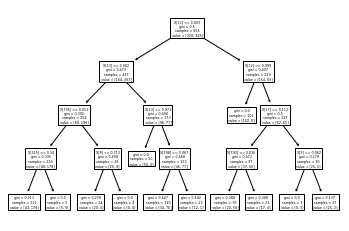

In [41]:
tree.plot_tree(tree_model)

### RANDOM FOREST

### CROSS VALIDATION

In [42]:
# parameters = {'max_depth':range(1,5), 'n_estimators':[10,20,30,40,50]}
parameters = {'max_depth':range(1,5)}
clf = GridSearchCV(RandomForestClassifier(n_estimators = 50), parameters)
clf.fit(X=X_train, y=y_train)

GridSearchCV(estimator=RandomForestClassifier(n_estimators=50),
             param_grid={'max_depth': range(1, 5)})

In [43]:
forest_model = clf.best_estimator_
# forest_model = RandomForestClassifier()

In [44]:
forest_model.fit(X_train, y_train)
train_guess = forest_model.predict(X_train)
test_guess = forest_model.predict(X_test)

In [45]:
accuracy_score(y_train, train_guess)

0.8841463414634146

In [46]:
accuracy_score(y_test, test_guess)

0.7592592592592593

In [47]:
confusion_matrix(y_test, test_guess)

array([[ 3, 19],
       [ 7, 79]])

In [48]:
test_guess

array(['Not favorite', 'Favorite', 'Not favorite', 'Not favorite',
       'Not favorite', 'Not favorite', 'Not favorite', 'Not favorite',
       'Not favorite', 'Not favorite', 'Not favorite', 'Favorite',
       'Not favorite', 'Not favorite', 'Not favorite', 'Not favorite',
       'Not favorite', 'Favorite', 'Not favorite', 'Not favorite',
       'Not favorite', 'Not favorite', 'Not favorite', 'Not favorite',
       'Not favorite', 'Not favorite', 'Not favorite', 'Not favorite',
       'Not favorite', 'Not favorite', 'Not favorite', 'Favorite',
       'Not favorite', 'Not favorite', 'Not favorite', 'Not favorite',
       'Not favorite', 'Not favorite', 'Not favorite', 'Not favorite',
       'Not favorite', 'Not favorite', 'Not favorite', 'Not favorite',
       'Not favorite', 'Not favorite', 'Not favorite', 'Not favorite',
       'Not favorite', 'Not favorite', 'Not favorite', 'Not favorite',
       'Not favorite', 'Not favorite', 'Not favorite', 'Not favorite',
       'Not favorite',

In [49]:
clf.best_params_

{'max_depth': 4}

In [50]:
prob = forest_model.predict_proba(X_test)

In [51]:
roc_auc_score(y_test, prob[:,1])

0.5861522198731501

### Gradient Boosting

### Cross Validation

In [52]:
parameters = {'max_depth':range(1,5), 'n_estimators':[90,100,110,120,130,140,150]}

clf = GridSearchCV(RandomForestClassifier(), parameters)
clf.fit(X=X_train, y=y_train)
clf.best_params_

{'max_depth': 4, 'n_estimators': 150}

In [53]:
GB =  clf.best_estimator_
# GB = GradientBoostingClassifier()

In [54]:
GB.fit(X_train, y_train)
train_guess = GB.predict(X_train)
test_guess = GB.predict(X_test)

In [55]:
accuracy_score(y_train, train_guess)

0.8978658536585366

In [56]:
accuracy_score(y_test, test_guess)

0.7407407407407407

In [57]:
confusion_matrix(y_test, test_guess)

array([[ 3, 19],
       [ 9, 77]])

In [58]:
prob = GB.predict_proba(X_test)

In [59]:
roc_auc_score(y_test, prob[:,1])

0.6231501057082452